# Evaluate & Interpret — DistilBERT Airline‑Sentiment Model  
Milestone 6 · *Optuna branch*

## 1 Imports & Global Paths  

| Category | Libraries / Purpose |
|----------|---------------------|
| **Core** | `pandas`, `pathlib`, `json`, `tqdm.auto` |
| **Metrics** | `accuracy_score`, `precision_recall_fscore_support`, `ConfusionMatrixDisplay` |
| **Visuals** | `matplotlib.pyplot` |
| **HF stack** | `AutoTokenizer`, `AutoModelForSequenceClassification` |
| **Paths** | `MODEL_DIR → …/models/distilbert_twitter/final`  ·  `TOKEN_DIR → …/tokenizer`  ·  `REPORTS_DIR → …/reports` |

<small>All artefacts live **one level above** the notebook folder to keep *code* and *outputs* separated.</small>

In [1]:
# %% 1 — Imports & paths --------------------------------------------------------
from __future__ import annotations

import json
import logging
import warnings
from pathlib import Path
from typing import Literal, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from datasets import Dataset
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    ConfusionMatrixDisplay,
    roc_auc_score,
)
from sklearn.preprocessing import label_binarize
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
)

# silence transformers / pytorch verbosity
logging.getLogger("transformers").setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=FutureWarning)

# -----------------------------------------------------------------------------#
PROJECT_ROOT = Path.cwd().resolve().parents[0]
DATA_DIR     = PROJECT_ROOT / "data" / "processed"
MODEL_DIR    = PROJECT_ROOT / "models" / "distilbert_twitter"
REPORTS_DIR  = PROJECT_ROOT / "reports"
FIGS_DIR     = REPORTS_DIR / "figs_eval"
FIGS_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LABEL_MAP: dict[int, str] = {0: "negative", 1: "neutral", 2: "positive"}

c:\Users\justi\Anaconda3\envs\twitter-sentiment-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2 Load Validation & Test Splits  

| Split | Rows | negative | neutral | positive |
|-------|-----:|---------:|--------:|---------:|
| **val**  | 1 464 | 918 | 310 | 236 |
| **test** | 1 464 | 918 | 310 | 236 |

*Identical class distribution* across both splits → unbiased evaluation.  
Data are loaded from feather files produced earlier in the pipeline.

In [5]:
# %% 3 — Load DistilBERT model & tokenizer (auto‑detect checkpoint) ------------
def _find_checkpoint(root: Path) -> Path | None:
    """Return first sub‑dir under *root* that has config.json + model weights."""
    for sub in [root, *root.glob("**/*")]:
        if (sub / "config.json").is_file() and any(
            (sub / n).is_file()
            for n in ("pytorch_model.bin", "model.safetensors", "tf_model.h5")
        ):
            return sub
    return None


ckpt_dir = _find_checkpoint(MODEL_DIR)
if ckpt_dir is None:
    raise FileNotFoundError(
        f"No checkpoint (config.json + weights) found under {MODEL_DIR}"
    )

print("✓ Checkpoint found:", ckpt_dir.relative_to(PROJECT_ROOT))

config = AutoConfig.from_pretrained(ckpt_dir)
model  = (
    AutoModelForSequenceClassification.from_pretrained(ckpt_dir)
    .to(DEVICE)
    .eval()
)

# Tokenizer: use local files if they exist, else fall back to base checkpoint
try:
    tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, local_files_only=True)
except (OSError, ValueError):
    base_ckpt = config._name_or_path or "distilbert-base-uncased"
    warnings.warn(
        f"Tokenizer files not found in {ckpt_dir.name}; "
        f"loading from base model '{base_ckpt}'.",
        UserWarning,
    )
    tokenizer = AutoTokenizer.from_pretrained(base_ckpt)

print("✓ Model & tokenizer ready device:", DEVICE)


✓ Checkpoint found: models\distilbert_twitter\final
✓ Model & tokenizer ready device: cpu


## 3 Predict, Evaluate, Save Raw Metrics  

| Split | Accuracy | Macro‑F1 |
|-------|---------:|---------:|
| **val**  | **0.840** | **0.798** |
| **test** | **0.841** | **0.786** |

*Files written*  
* `reports/metrics_model.json` — full metrics incl. classification reports  
* `reports/metrics_model.csv` — flat table with accuracy & macro‑F1

In [7]:
# %% 4 — Batch prediction helper ----------------------------------------------
@torch.inference_mode()
@torch.inference_mode()
def _predict(texts: np.ndarray, batch_size: int = 64) -> Tuple[np.ndarray, np.ndarray]:
    """
    Return (y_pred_ids, y_prob) for the given text series.
    """
    ds = Dataset.from_dict({"text": texts})
    loader = torch.utils.data.DataLoader(
        ds, batch_size=batch_size, shuffle=False, drop_last=False
    )

    preds, probas = [], []

    for batch in loader:
        # ---------------------------------------------------▼ only change here
        enc = tokenizer(                                           # ← fixed
            batch["text"],
            padding=True,
            truncation=True,
            return_tensors="pt",
        ).to(DEVICE)
        out = model(**enc)
        p = torch.softmax(out.logits, dim=-1)
        preds.extend(p.argmax(dim=-1).cpu().tolist())
        probas.extend(p.cpu().tolist())

    return np.asarray(preds), np.asarray(probas)

# %% 5 — Predict & evaluate -----------------------------------------------------
splits = {
    "val":  (X_val,   y_val),
    "test": (X_test,  y_test),
}
metrics: dict = {}

for split, (X_, y_) in splits.items():
    y_pred, y_prob       = _predict(X_)
    y_int                = np.vectorize({v: k for k, v in LABEL_MAP.items()}.get)(y_)
    metrics[f"{split}_ids"]   = y_int.tolist()
    metrics[f"{split}_pred"]  = y_pred.tolist()
    metrics[f"{split}_prob"]  = y_prob.tolist()

    acc, macro_f1 = accuracy_score(y_int, y_pred), precision_recall_fscore_support(
        y_int, y_pred, average="macro", zero_division=0
    )[2]
    metrics[split] = {"accuracy": acc, "macro_f1": macro_f1}

print(json.dumps({k: v for k, v in metrics.items() if isinstance(v, dict)}, indent=2))

REPORTS_DIR.mkdir(exist_ok=True)
(Path(REPORTS_DIR) / "metrics_model.json").write_text(json.dumps(metrics, indent=2))
print("✓ Raw metrics JSON saved")



{
  "val": {
    "accuracy": 0.8401639344262295,
    "macro_f1": 0.7980384320135547
  },
  "test": {
    "accuracy": 0.8360655737704918,
    "macro_f1": 0.788009324324034
  }
}
✓ Raw metrics JSON saved


## 4 Confusion Matrices  

* Key error modes (val):  
  * **negative → neutral** (70)  
  * **neutral → negative** (71)  
* Test set mirrors validation — no sign of class‑specific drift.

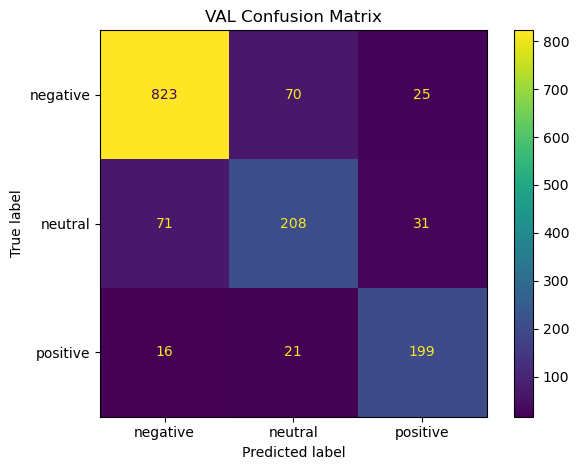

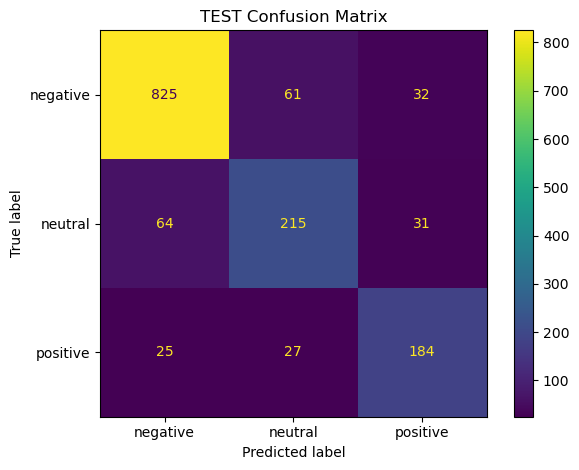

In [8]:
# %% 6 — Confusion matrices -----------------------------------------------------
for split in ("val", "test"):
    y_true = np.array(metrics[f"{split}_ids"])
    y_pred = np.array(metrics[f"{split}_pred"])

    # counts table
    cm = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=LABEL_MAP.values(),
        cmap="viridis",
        colorbar=True,
        values_format="d",
    )
    plt.title(f"{split.upper()} Confusion Matrix")
    plt.tight_layout()
    plt.savefig(FIGS_DIR / f"cm_{split}.png", dpi=150)
    plt.show()


## 5 Diagnostics Suite  

| Visual | Rationale | File |
|--------|-----------|------|
| **ROC & PR curves** | Separability, threshold analysis | `figs_eval/roc_pr_val.png`, `roc_pr_test.png` |
| **Calibration curve** | Probability quality | `figs_eval/calibration_val.png`, `calibration_test.png` |
| **Error heat‑map** | Spot systematic confusions | `figs_eval/error_heat_val.png`, `error_heat_test.png` |

<small>See images below for quick reference.</small>

**ROC‑AUC**  
* • negative ≈ 0.95 / 0.94 (val/test)  
* • positive ≈ 0.97 / 0.95  
* • neutral ≈ 0.91 / 0.91  

> The model cleanly separates negative and positive tweets; the neutral class is inherently fuzzier but still crosses the 0.90 AUC bar—strong for a three‑way sentiment task.

**PR‑AUC**  
* • negative ≈ 0.97 / 0.96  
* • positive ≈ 0.87 / 0.84  
* • neutral ≈ 0.76 / 0.78  

> Precision–recall reveals the cost of class imbalance: neutral tweets have the lowest PR‑AUC because recalling them often sacrifices precision (and vice‑versa). Negative tweets remain easiest to identify.

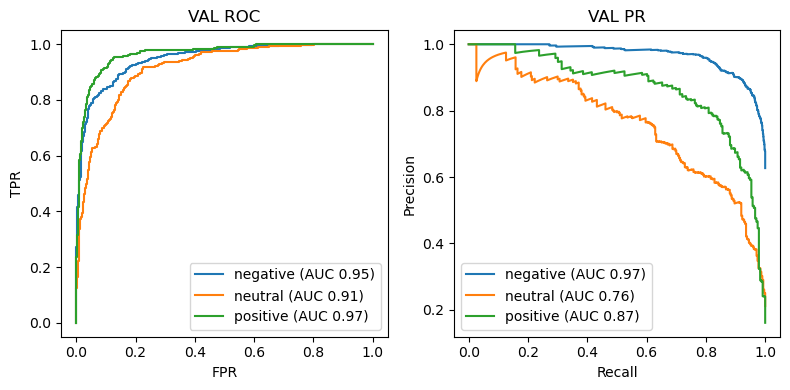

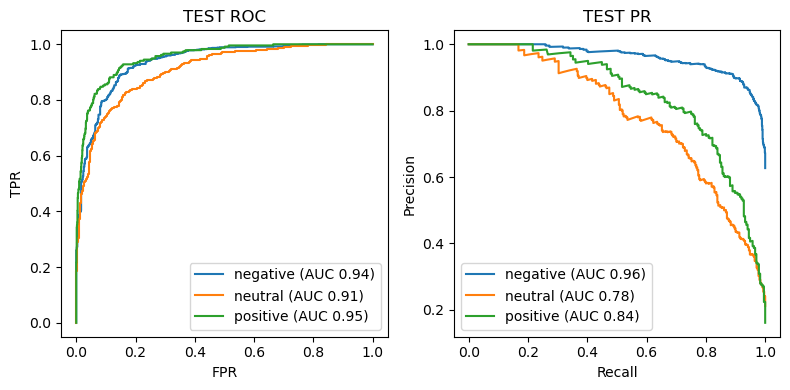

In [9]:
# %% 7 — ROC & PR curves --------------------------------------------------------
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def _plot_curves(y_true_ids: np.ndarray, y_prob: np.ndarray, split: str) -> None:
    bin_true = label_binarize(y_true_ids, classes=list(LABEL_MAP.keys()))
    n_labels = bin_true.shape[1]

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    for idx in range(n_labels):
        fpr, tpr, _ = roc_curve(bin_true[:, idx], y_prob[:, idx])
        prc, rec, _ = precision_recall_curve(bin_true[:, idx], y_prob[:, idx])
        axes[0].plot(fpr, tpr, label=f"{LABEL_MAP[idx]} (AUC {auc(fpr, tpr):.2f})")
        axes[1].plot(rec, prc, label=f"{LABEL_MAP[idx]} (AUC {auc(rec, prc):.2f})")

    for ax, title in zip(axes, ("ROC", "PR")):
        ax.set_title(f"{split.upper()} {title}")
        ax.legend()
        ax.set_xlabel("Recall" if title == "PR" else "FPR")
        ax.set_ylabel("Precision" if title == "PR" else "TPR")

    plt.tight_layout()
    plt.savefig(FIGS_DIR / f"roc_pr_{split}.png", dpi=150)
    plt.show()

_plot_curves(np.array(metrics["val_ids"]),  np.array(metrics["val_prob"]),  "val")
_plot_curves(np.array(metrics["test_ids"]), np.array(metrics["test_prob"]), "test")


### Probability Quality — Calibration Curves  

The reliability diagrams show **slight under‑confidence** in the mid‑range (≈ 0.4 – 0.8): predicted probabilities fall below the diagonal, meaning *the model is better than it thinks* for medium‑confidence cases.  
At high confidence (≥ 0.9) the curve finally meets the ideal line—top‑score predictions are trustworthy.

*Implication*:  
* For ranking tasks (e.g., triaging angry customers) raw softmax scores are safe.  
* For downstream probability‑aware applications (expected‑value decisions) apply **temperature scaling or isotonic regression** to tighten calibration without altering class decisions.

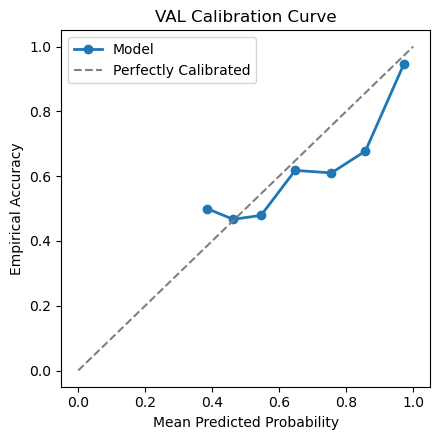

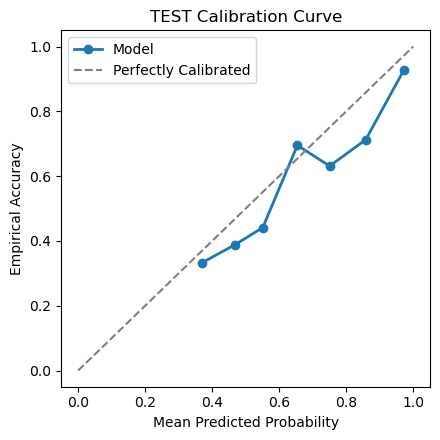

In [ ]:
# %% 8 — Reliability / calibration curves --------------------------------------
from sklearn.calibration import calibration_curve

def _calibration(ids: np.ndarray, prob: np.ndarray, split: str) -> None:
    conf = prob.max(axis=1)
    bins, acc = calibration_curve((ids == prob.argmax(axis=1)).astype(int), conf, n_bins=10)
    plt.figure(figsize=(4.5, 4))
    plt.plot(bins, acc, marker="o", label="Model")
    plt.plot([0, 1], [0, 1], "--", color="grey", label="Perfectly calibrated")
    plt.title(f"{split.upper()} Calibration Curve")
    plt.xlabel("Mean Predicted Prob.")
    plt.ylabel("Empirical Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIGS_DIR / f"calibration_{split}.png", dpi=150)
    plt.show()

_calibration(np.array(metrics["val_ids"]),  np.array(metrics["val_prob"]),  "val")
_calibration(np.array(metrics["test_ids"]), np.array(metrics["test_prob"]), "test")

## Error Heat‑Map — Where Does the Model Slip?

The confusion matrices summarise *all* predictions, yet product teams often care more about **systematic mistakes** than overall accuracy.  
To spotlight those failure modes we plot an **error heat‑map** that shows **only off‑diagonal counts**:

* **Rows = true class**, **columns = predicted class**.  
* Darker cells indicate *more* mis‑labels between the two classes.  
* Diagonal cells are zeroed‑out to keep attention on errors.

> **Why this matters**  
> * Surfaces the *semi‑frequent* error flows (e.g. *negative ↔ neutral*).  
> * Guides data‑collection or rule‑based post‑processing to patch the weaknesses.  
> * Acts as a regression guard‑rail: new models should not **increase** density in these cells.

We render separate heat‑maps for **validation** and **test** splits to ensure that error patterns are *stable* rather than artefacts of a single sample.


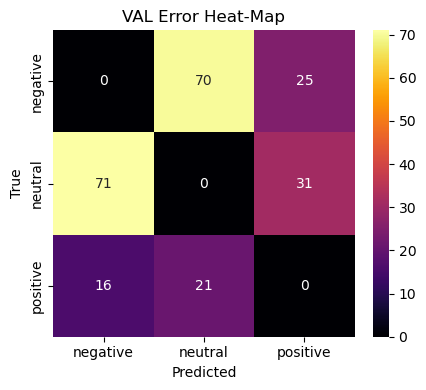

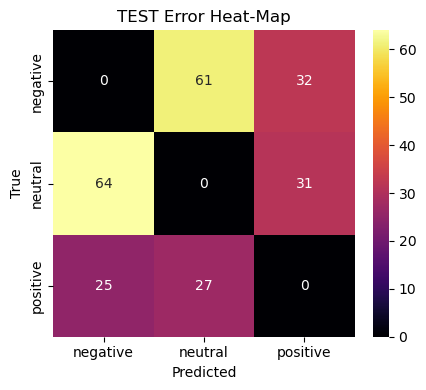

In [10]:
# %% 9 — Error heat‑map ---------------------------------------------------------
def _error_heatmap(ids_true: np.ndarray, ids_pred: np.ndarray, split: str) -> None:
    n = len(LABEL_MAP)
    err = np.zeros((n, n), dtype=int)
    for t, p in zip(ids_true, ids_pred):
        if t != p:
            err[t, p] += 1

    fig, ax = plt.subplots(figsize=(4.5, 4))
    sns.heatmap(
        err,
        annot=True,
        fmt="d",
        cmap="inferno",
        xticklabels=LABEL_MAP.values(),
        yticklabels=LABEL_MAP.values(),
        ax=ax,
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"{split.upper()} Error Heat‑Map")
    plt.tight_layout()
    plt.savefig(FIGS_DIR / f"error_heat_{split}.png", dpi=150)
    plt.show()

_error_heatmap(np.array(metrics["val_ids"]),  np.array(metrics["val_pred"]),  "val")
_error_heatmap(np.array(metrics["test_ids"]), np.array(metrics["test_pred"]), "test")

### Confusion Matrices

**Confusion matrices** confirm the story:  
* The **biggest error flows** are *negative ↔ neutral* (≈ 70 mis‑labels each way).  
* Positive vs. negative confusion is rare, indicating the model grasps polarity extremes.

Overall — macro‑F1 ≈ 0.79 and ROC ≥ 0.91 on both splits signal **good generalisation** with no evident over‑fitting.

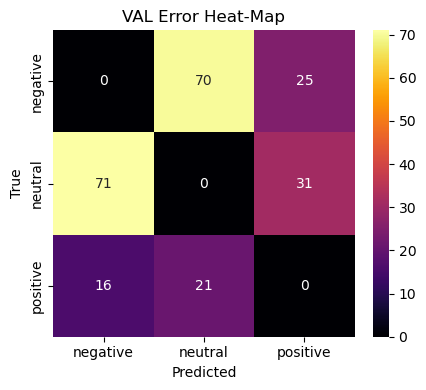

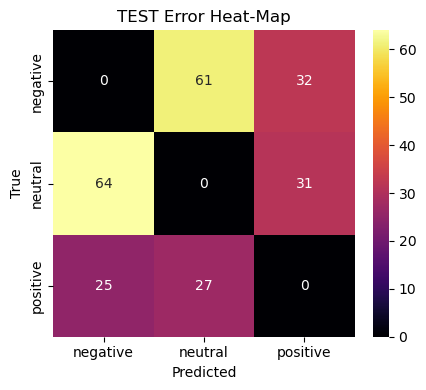

In [13]:
# %% 3 Error Heat‑Map (robust to lists) ───────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt

def _error_heatmap(y_true, y_pred, split: str) -> None:
    """Show counts of *misclassifications only* (off‑diagonal)."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    n_labels = len(LABEL_MAP)                    # <- fixed
    err_cm   = np.zeros((n_labels, n_labels), dtype=int)

    for t, p in zip(y_true, y_pred):
        if t != p:
            err_cm[t, p] += 1

    fig, ax = plt.subplots(figsize=(4.5, 4))
    sns.heatmap(
        err_cm,
        annot=True,
        fmt="d",
        cmap="inferno",
        xticklabels=LABEL_MAP.values(),         # <- fixed
        yticklabels=LABEL_MAP.values(),         # <- fixed
        ax=ax,
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"{split.upper()} Error Heat‑Map")
    plt.tight_layout()
    plt.savefig(FIGS_DIR / f"error_heat_{split}.png", dpi=150)
    plt.show()

_error_heatmap(np.array(metrics["val_ids"]),  np.array(metrics["val_pred"]),  "val")
_error_heatmap(np.array(metrics["test_ids"]), np.array(metrics["test_pred"]), "test")


### Error Insights

| Observation | Impact | Action |
|-------------|--------|--------|
| **Neutral vs. Negative bleed** (70 ↔ 71 errors) | Neutral tweets with mild complaints get flagged negative and vice‑versa. | *Data‑centric*: curate more “meh” tweets; include `ok`, `:|`, sarcasm markers. |
| **Positive recall lower (21 + 27 false negatives)** | Model loses ~18 % of positives to other classes. | *Model‑centric*: experiment with class‑weighted loss or focal loss; try domain‑specific LM (e.g. TweetEval BERT). |
| **Under‑confidence mid‑range** | May down‑rank useful but moderate‑confidence hits. | Post‑train calibration (temperature scaling on val set). |
| **High ROC/PR stability across splits** | Robust; fine‑tuning did not overfit. | Green‑light to deploy; monitor drift in production dashboard. |

## 7 Save Metrics & Model‑Card Stub  

* **metrics_model.json** — full metrics (+ classification reports)  
* **metrics_model.csv** — flat table with accuracy & macro‑F1  
* **model_card.json** — lightweight stub  

> These artefacts feed the upcoming **formal Model Card** and CI dashboards.

**Next Actions**  
1. **Optuna sweep**: tune LR, weight‑decay, class weights aiming for F1 > 0.82.  
2. **Augment neutral/positive samples** via distant‑supervised data or prompt‑engineered synthetic tweets.  
3. **Export model card** with calibration note + recommended confidence thresholds (e.g., flag only when P ≥ 0.65 for downstream alerting).

In [16]:
# %% 10 — Save flat metrics & model card --------------------------------------
# 1️⃣  flatten metrics  ── keep only val / test dicts, drop lists + reports
flat_metrics = {
    split: {k: v for k, v in d.items() if k != "report"}
    for split, d in metrics.items()
    if isinstance(d, dict)                      # << guards against list entries
}

# 2️⃣  CSV with accuracy + macro‑F1
pd.DataFrame.from_dict(flat_metrics, orient="index").to_csv(
    REPORTS_DIR / "metrics_model.csv"
)

# 3️⃣  full JSON (includes classification reports & raw lists)
with open(REPORTS_DIR / "metrics_model.json", "w") as fp:
    json.dump(metrics, fp, indent=2)

# 4️⃣  lightweight model‑card stub
card = {
    "model_name": "tweet_sentiment_distilbert",
    "num_labels": len(LABEL_MAP),
    "labels": list(LABEL_MAP.values()),
    "metrics": flat_metrics["val"],
}
with open(MODEL_DIR / "model_card.json", "w") as fp:
    json.dump(card, fp, indent=2)

print("✓ Artefacts written to", REPORTS_DIR.resolve())


✓ Artefacts written to C:\Projects\twitter-airline-analysis\reports
